The current notebook contains a comprehensive analysis pipeline that begins with the retrieval of gene expression data in CEL file format from GEO, which is then processed and transformed into a tabular format with sample IDs in rows and gene IDs in columns. If obtaining the data from GEO is not necessary or if the gene expression matrix is already available, this step may be skipped.

Following data preparation, the Quality Check (QC) section is essential for ensuring the integrity and reliability of the data. This step involves checking for batch effects, outliers, and assessing the distribution of gene expression data to determine the quality of the dataset.

Next, the Tumor Microenvironment (TME) classification section is performed using the processed gene expression data from TCGA. This step allows for the classification of samples based on their respective TME subtypes.

Finally, the Clustering section is an optional step recommended for experienced users only. This section involves the creation of a reference signatures cohort based on a reference gene expression cohort provided by the user. The resulting cohort can then be used in place of the default TCGA cohort in the TME classification section. However, it is advised to use the default cohort to ensure accurate and unbiased results during classification.

# Import of python base packages

If you have oppened current file in view only mode but want to use the code please go back to our repositories Setup section and follow the instructions (link provided below).
https://github.com/BostonGene/MFP

In [1]:
%load_ext autoreload
%matplotlib inline
%config IPCompleter.use_jedi = False

import os
import pandas as pd
import numpy as np
import seaborn as sns
import pathlib
import subprocess
import logging
import csv
import matplotlib.pyplot as plt
import umap
import matplotlib.pyplot as plt
from IPython.display import SVG
from tqdm import tqdm_notebook

%config InlineBackend.figure_format = 'png'
plt.rcParams['pdf.fonttype'] = 'truetype'
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['figure.dpi'] = 120

In [2]:
from portraits.plotting import pca_plot, umap_plot, distplot_qc
from portraits.mapping import get_gs_for_probes_from_3col,get_expressions_for_gs
from portraits.utils import read_gene_sets, ssgsea_formula, median_scale
from portraits.classification import KNeighborsClusterClassifier
from portraits.clustering import clustering_profile_metrics, clustering_profile_metrics_plot,clustering_select_best_tr

In [3]:
%load_ext rpy2.ipython

In [4]:
#Constants

EXPRESSIONS_MATRIX = './expressions.tsv'
TEST_EXPRESSION_MATRIX = 'Test/expressions.tsv'
TCGA_SIGNATURES = 'Cohorts/Pan_TCGA/signatures.tsv'
TCGA_COHORTS_ANNOTATION = 'Cohorts/Pan_TCGA/annotation.tsv'
CLASSIFIED_SAMPLES = 'classified_samples.tsv'
GENE_SIGNATURES = 'signatures/gene_signatures.gmt'
SUBTYPE_FINAL_CLUSTERS = 'samples_subtyping_by_tme.tsv'

# Example Data preparation

Example will be shown on Ulloa-Montoya GSE35640, GPL570 sample

## Get the example data from GEO

In [8]:
#initialization and creation of the temporary directory for the cel files 

GSE = 'GSE35640'
PLATFORM = 'GPL570'
current_dir = pathlib.Path().parent.absolute()
dir_to_process = str(current_dir / 'TMPDIR')

In [9]:
if not os.path.exists(dir_to_process):
     os.mkdir(dir_to_process)

In [10]:
with open(os.devnull, "w") as f:
    subprocess.run([
        'wget',
        f'ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE35nnn/{GSE}/suppl/{GSE}_RAW.tar'
    ],stdout=f, stderr=subprocess.STDOUT );

In [11]:
subprocess.run([
    'tar',
    '-xf',
    f'{GSE}_RAW.tar',
    '-C', dir_to_process
])
subprocess.run([
    'rm',
    f'{GSE}_RAW.tar'
])

CompletedProcess(args=['rm', 'GSE35640_RAW.tar'], returncode=0)

In [12]:
os.listdir(dir_to_process)

['GSM872328_MAGE008_sample_1.CEL.gz',
 'GSM872329_MAGE008_sample_2.CEL.gz',
 'GSM872330_MAGE008_sample_3.CEL.gz',
 'GSM872331_MAGE008_sample_4.CEL.gz',
 'GSM872332_MAGE008_sample_5.CEL.gz',
 'GSM872333_MAGE008_sample_6.CEL.gz',
 'GSM872334_MAGE008_sample_7.CEL.gz',
 'GSM872335_MAGE008_sample_8.CEL.gz',
 'GSM872336_MAGE008_sample_9.CEL.gz',
 'GSM872337_MAGE008_sample_10.CEL.gz',
 'GSM872338_MAGE008_sample_11.CEL.gz',
 'GSM872339_MAGE008_sample_12.CEL.gz',
 'GSM872340_MAGE008_sample_13.CEL.gz',
 'GSM872341_MAGE008_sample_14.CEL.gz',
 'GSM872342_MAGE008_sample_15.CEL.gz',
 'GSM872343_MAGE008_sample_16.CEL.gz',
 'GSM872344_MAGE008_sample_17.CEL.gz',
 'GSM872345_MAGE008_sample_18.CEL.gz',
 'GSM872346_MAGE008_sample_19.CEL.gz',
 'GSM872347_MAGE008_sample_20.CEL.gz',
 'GSM872348_MAGE008_sample_21.CEL.gz',
 'GSM872349_MAGE008_sample_22.CEL.gz',
 'GSM872350_MAGE008_sample_23.CEL.gz',
 'GSM872351_MAGE008_sample_24.CEL.gz',
 'GSM872352_MAGE008_sample_25.CEL.gz',
 'GSM872353_MAGE008_sample_26.CEL.

## Extracting expression values from CEL file

In case of affy arrays without special probes we have to use justRMA<br>
For GPL570/GPL96 we can use gcrma

In [13]:
%%R

# Loading required R packages
library(affy)
library(annotate)
library(gcrma)

R[write to console]: Loading required package: BiocGenerics

R[write to console]: 
Attaching package: ‘BiocGenerics’


R[write to console]: The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


R[write to console]: The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


R[write to console]: Loading required package: Biobase

R[write to console]: Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.


R[write to console]

In [14]:
%%R -i dir_to_process -o normalized_expression

# Bulk read cell files
raw_expression <- ReadAffy(celfile.path = dir_to_process)

# Normalize expression using RMA
rma_normalized <- gcrma(raw_expression)

# Retrieving expressions from dataset
normalized_expression <- as.data.frame(exprs(rma_normalized))

R[write to console]: 



Adjusting for optical effect.................................................................Done.
Computing affinities.Done.
Adjusting for non-specific binding.................................................................Done.
Normalizing
Calculating Expression


In [15]:
normalized_expression.head()

,GSM872328_MAGE008_sample_1.CEL.gz,GSM872329_MAGE008_sample_2.CEL.gz,GSM872330_MAGE008_sample_3.CEL.gz,GSM872331_MAGE008_sample_4.CEL.gz,GSM872332_MAGE008_sample_5.CEL.gz,GSM872333_MAGE008_sample_6.CEL.gz,GSM872334_MAGE008_sample_7.CEL.gz,GSM872335_MAGE008_sample_8.CEL.gz,GSM872336_MAGE008_sample_9.CEL.gz,GSM872337_MAGE008_sample_10.CEL.gz,...,GSM872383_MAGE008_sample_56.CEL.gz,GSM872384_MAGE008_sample_57.CEL.gz,GSM872385_MAGE008_sample_58.CEL.gz,GSM872386_MAGE008_sample_59.CEL.gz,GSM872387_MAGE008_sample_60.CEL.gz,GSM872388_MAGE008_sample_61.CEL.gz,GSM872389_MAGE008_sample_62.CEL.gz,GSM872390_MAGE008_sample_63.CEL.gz,GSM872391_MAGE008_sample_64.CEL.gz,GSM872392_MAGE008_sample_65.CEL.gz
1007_s_at,9.816090,6.474644,9.113994,7.044742,8.719946,4.852191,7.190953,8.636192,5.623183,7.433451,...,6.287400,7.017124,7.533525,7.042195,8.809050,8.198514,8.457781,7.530108,4.724734,9.222943
1053_at,5.664499,6.540040,5.569006,5.745150,4.690936,5.923728,5.700713,5.120923,5.394368,6.704893,...,5.992869,6.754348,5.943736,6.333925,6.063615,6.360003,6.073347,7.141974,7.191548,5.611221
117_at,8.394219,6.083483,6.587381,6.092671,3.411626,3.791668,5.667734,4.965991,4.475886,4.443469,...,3.296701,5.638913,3.205921,3.471334,3.682211,8.971476,4.343425,5.738228,4.807307,10.331267
121_at,2.390202,2.345001,2.390202,2.388071,2.390202,2.390202,2.454035,2.390202,3.128954,2.390202,...,2.320004,2.390202,2.411101,2.390202,2.390202,2.390202,2.380696,2.390202,2.882576,2.434246
1255_g_at,2.223272,2.223272,2.223272,2.223272,2.223272,2.223272,2.223272,2.223272,2.223272,2.223272,...,2.223272,2.223272,2.223272,2.223272,2.223272,2.223272,2.348901,2.223272,2.223272,2.223272


Trimming names to make table columns more readable

In [16]:
normalized_expression.columns = normalized_expression.columns.to_series().apply(lambda x: x.split('_')[0]).values
normalized_expression.head()

,GSM872328,GSM872329,GSM872330,GSM872331,GSM872332,GSM872333,GSM872334,GSM872335,GSM872336,GSM872337,...,GSM872383,GSM872384,GSM872385,GSM872386,GSM872387,GSM872388,GSM872389,GSM872390,GSM872391,GSM872392
1007_s_at,9.816090,6.474644,9.113994,7.044742,8.719946,4.852191,7.190953,8.636192,5.623183,7.433451,...,6.287400,7.017124,7.533525,7.042195,8.809050,8.198514,8.457781,7.530108,4.724734,9.222943
1053_at,5.664499,6.540040,5.569006,5.745150,4.690936,5.923728,5.700713,5.120923,5.394368,6.704893,...,5.992869,6.754348,5.943736,6.333925,6.063615,6.360003,6.073347,7.141974,7.191548,5.611221
117_at,8.394219,6.083483,6.587381,6.092671,3.411626,3.791668,5.667734,4.965991,4.475886,4.443469,...,3.296701,5.638913,3.205921,3.471334,3.682211,8.971476,4.343425,5.738228,4.807307,10.331267
121_at,2.390202,2.345001,2.390202,2.388071,2.390202,2.390202,2.454035,2.390202,3.128954,2.390202,...,2.320004,2.390202,2.411101,2.390202,2.390202,2.390202,2.380696,2.390202,2.882576,2.434246
1255_g_at,2.223272,2.223272,2.223272,2.223272,2.223272,2.223272,2.223272,2.223272,2.223272,2.223272,...,2.223272,2.223272,2.223272,2.223272,2.223272,2.223272,2.348901,2.223272,2.223272,2.223272


In [17]:
subprocess.run(['rm',  '-r','TMPDIR/'])
# deleting unnecessary files

CompletedProcess(args=['rm', '-r', 'TMPDIR/'], returncode=0)

## Converting probe ids to HUGO gene symbols

If your file is not from GEO or retrieved from CEL files then you can skip to the final QC.

Get chip SOFT file and make a 3-col file out of that.<br>

1st column: probe id<br>
2nd column: gene symbol column (as is with '///')<br>
3rd column: entrez id (not needed for the study)

Script and description to download and extract soft file with 3 columns.

Because we are using data from GEO here is a link to SOFT file of Ulloa-Montoya sample.

You can also find it by going to https://www.ncbi.nlm.nih.gov/geo/ and in the search bar you can type the number of GPL platform in our case it is GPL570 and you will be directed to https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GPL570

Here at the end of the page you will see Annotation SOFT table.
Click on that button and it will automatically download (in our example GPL570.annot.gz) SOFT annotation table for your sample.
And then upload the file to the environment.

In [18]:
# If you want to download your SOFT annotation table programmatically use the script below 
# By changing the value of PLATFORM
# To the value of your desired GPL platform

with open(os.devnull, "w") as f:
    subprocess.run([
        'wget',
        f'ftp://ftp.ncbi.nlm.nih.gov/geo/platforms/GPLnnn/{PLATFORM}/annot/{PLATFORM}.annot.gz'
    ], stdout=f, stderr=subprocess.STDOUT)

In [19]:
# When data upload is complete run the script below in your terminal to unzip your file
subprocess.run(['gunzip', f'{PLATFORM}.annot.gz'])
# After the unzipping process you will have GPL570.annot.gz file.

CompletedProcess(args=['gunzip', 'GPL570.annot.gz'], returncode=0)

Subsetting SOFT file to have 3 columns 

In [20]:
# Removing header from SOFT file so it won't cause any problems in further processes
subprocess.run("sed '1,/^ID/d' GPL570.annot > GPL570.beheaded.annot", shell = True)

CompletedProcess(args="sed '1,/^ID/d' GPL570.annot > GPL570.beheaded.annot", returncode=0)

In [21]:
gene_SOFT_annotations = pd.read_csv(f'{PLATFORM}.beheaded.annot', sep = '\t', header = None)
gene_SOFT_annotations = gene_SOFT_annotations.iloc[:, [0, 2, 3]]

# Renaming columns
gene_SOFT_annotations = gene_SOFT_annotations.rename(columns = {2: 1, 3 : 2})
gene_SOFT_annotations.to_csv(f'{PLATFORM}.3col', sep = '\t',  index=False, quoting=csv.QUOTE_NONNUMERIC)

/tmp/ipykernel_82/3515344537.py:1: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  gene_SOFT_annotations = pd.read_csv(f'{PLATFORM}.beheaded.annot', sep = '\t', header = None)


In [22]:
gene_SOFT_annotations.head()

,0,1,2
0,1007_s_at,MIR4640///DDR1,100616237///780
1,1053_at,RFC2,5982
2,117_at,HSPA6,3310
3,121_at,PAX8,7849
4,1255_g_at,GUCA1A,2978


In [23]:
#deleting all unnecessary files
subprocess.run(['rm', f'{PLATFORM}.annot'])
subprocess.run(['rm', f'{PLATFORM}.beheaded.annot'])

CompletedProcess(args=['rm', 'GPL570.beheaded.annot'], returncode=0)

In [24]:
probes_gs_dict = get_gs_for_probes_from_3col(f'{PLATFORM}.3col', normalized_expression.index.tolist())

In [25]:
pd.Series(probes_gs_dict).head(10)

1007_s_at    [MIR4640, DDR1]
1053_at               [RFC2]
117_at               [HSPA6]
121_at                [PAX8]
1255_g_at           [GUCA1A]
1294_at      [MIR5193, UBA7]
1316_at               [THRA]
1320_at             [PTPN21]
1405_i_at             [CCL5]
1431_at             [CYP2E1]
dtype: object

In [ ]:
series = pd.Series(probes_gs_dict)
annotated_expression = get_expressions_for_gs(series, normalized_expression, 'max').T.sort_index()

annotated_expression.to_csv(SUBTYPE_FINAL_CLUSTERS, sep='\t', index=True)

# Quality check (QC)

In [7]:
#If you want to test the code starting from QC and skiping the Data Preparation part please uncomment this code
# annotated_expression = pd.read_csv(TEST_EXPRESSION_MATRIX, sep='\t', index_col=0)

The Quality Control (QC) section is tasked with identifying batches, outliers, and assessing the normality of data distribution using various techniques such as PCA plot, UMAP plot, and distribution plot.

As part of your role in this section, you will be provided with examples of both poor and good datasets, which will help you identify the visual differences between them and understand the types of issues that can arise in data. This knowledge will enable you to effectively assess the quality of the data and identify any potential issues that may impact downstream analyses.

## Batch detection

This section is responsible for identifying any potential batch effects in the data using UMAP and PCA analyses. The results of these analyses are then plotted to visualize any potential batches in the data.

If you are not familiar with batch effects please follow the link below for more information:
https://towardsdatascience.com/batch-effects-c71c886ca9c5

To illustrate this process, an example is provided below with two side-by-side plots. The plot on the left is a good example with no identified issues, whereas the plot on the right exhibits potential batch effects.

One key difference between the two figures is the presence of two distinct groups of data points that are separated from each other in the batch-affected example. This is indicative of a potential batch effect, which can have significant impacts on downstream analyses.

If the plot of your data resembles the one on the right, it is crucial to take action to remove any identified batch effects to ensure accurate and reliable analysis.

For the instructions of batch effects removal use the link provided below:
https://github.com/chichaumiau/removeBatcheffect

![Umap Example](plots/umap_examples.svg)

<AxesSubplot:>

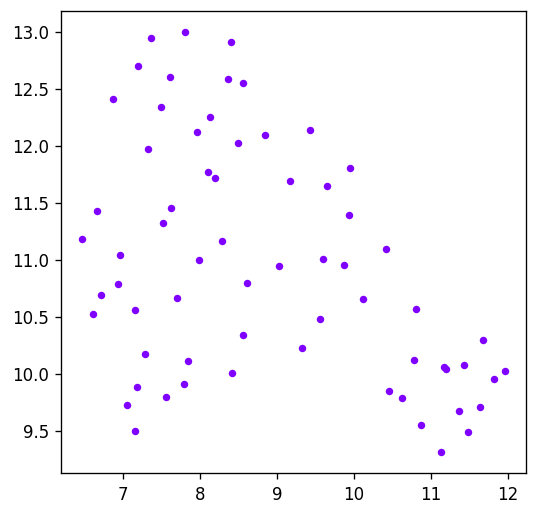

In [8]:
# generating umap_plot for our input data
umap_plot(annotated_expression.T, legend = 'Out')

To further enhance the significance of our analysis, we perform PCA analyses and plot the results to ensure that our data is free from any batch effects.

An illustrative example is provided below, where it is clear that the presence of batches is reflected in the plot as two distinct groups of data points that are far from each other. In contrast, a normal dataset appears as a single group of data points that are relatively close to each other, as reflected in the PCA plot.

This step is essential to ensure that our data is free from any systematic variation that could confound our analyses, and to ensure that any observed effects are biologically meaningful.

![Pca batches example not colored](plots/pca_batches_example_not_colored.svg)

![Pca batches example not colored](plots/pca_batches_example_colored.svg)

<AxesSubplot:xlabel='PCA 1 component 14% variance explained', ylabel='PCA 2 component 10% variance explained'>

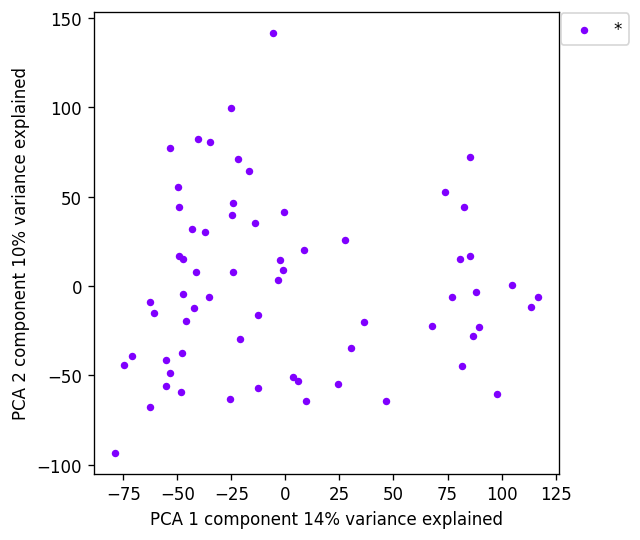

In [9]:
#generating the pca plot for the annotated_expressions
pca_plot(annotated_expression.T, legend = 'out')

## Outlier detection

The purpose of this section is to identify outliers in the annotated_expression data through PCA analysis and the generation of corresponding plots.

The code cell below generates a PCA plot of the transposed annotated_expression data. Transposing the data allows for the sample IDs to be located in the row positions, which facilitates dimension reduction based on samples. This plot can help identify any outliers that may exist in the data.

An example of two datasets is provided below, with one dataset containing outliers and the other dataset being normal.

In the plot on the left, two data points are far away from the main group of data points, indicating the presence of outliers in the dataset. In contrast, the data points in the plot on the right are relatively close to each other, with no outliers detected. It is important to carefully examine plots like these to detect any outliers that may exist in the data.

To get more familiar with outliers and their removal use the link below:
https://www.geeksforgeeks.org/detect-and-remove-the-outliers-using-python/

![PCA outliers example](plots/pca_outliers_example.svg)

<AxesSubplot:xlabel='PCA 1 component 14% variance explained', ylabel='PCA 2 component 10% variance explained'>

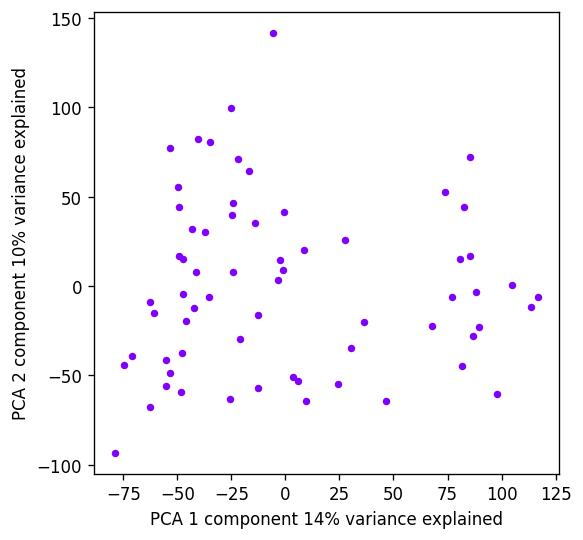

In [35]:
# Generating pca plot for annotated_expression to find outliers
pca_plot(annotated_expression.T, legend= None)

If the pca_plot of your data looks like the plot on left from the above example please remove the outliers from your dataset.

In [36]:
#checking of there are repetitive values or not
annotated_expression.columns.value_counts().max()

1

## Data distribution check

As with the previous sections, an example of two gene expression datasets is provided below, with one exhibiting good quality and the other exhibiting poor quality, as indicated by their respective distribution plots.

In the plot on the right, the expression values start off very low and then rise before dropping down. This pattern suggests potential gene degradation, which can compromise the reliability and accuracy of downstream analyses. In contrast, the distribution plot on the left appears to be normal, indicating good quality gene expression data.

It is essential to carefully examine the distribution plots of gene expression data to ensure that the data meets the necessary quality criteria for accurate and reliable analyses. Any deviations from normal distributions or patterns of gene expression that may indicate gene degradation should be carefully investigated and, if necessary, corrected to ensure high-quality data.

![Data distribution example](plots/data_distribution_example.svg)

The code snippet provided generates a visualization of the distribution of annotated expression values, which appears to be normal and distinct from the atypical distribution depicted in the previous example. This type of data visualization is useful for identifying trends and patterns in gene expression data and can aid in the quality control and preprocessing of the data.

/home/jovyan/venvs/QA3.9-common/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

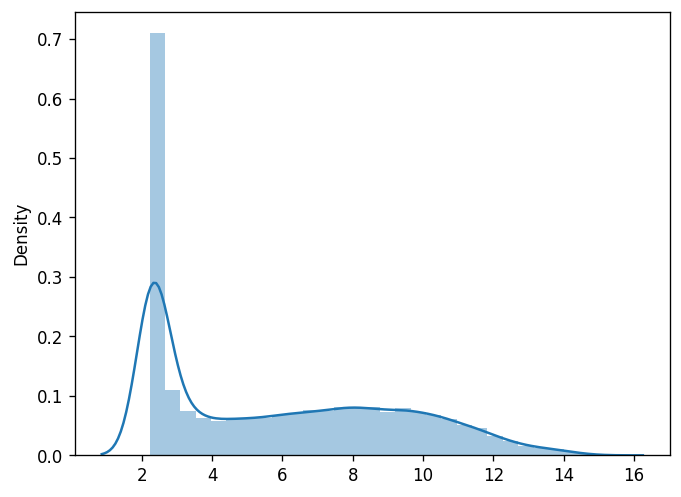

In [39]:
sns.distplot(annotated_expression.mean(axis=1), kde = True)

If your data plot is similar to the distribution of the normal data on the right then you can continue your analyses whereas if it is similar to the one on left then your data is abnormal and might have RNA degradation. During RNA degradation case please stop the analyses to not have any wrong calculations and choose a new dataset.

In [40]:
#Printing the dataframe to know how it looks in table form 
annotated_expression.head()

,GSM872328,GSM872329,GSM872330,GSM872331,GSM872332,GSM872333,GSM872334,GSM872335,GSM872336,GSM872337,...,GSM872383,GSM872384,GSM872385,GSM872386,GSM872387,GSM872388,GSM872389,GSM872390,GSM872391,GSM872392
A1BG,3.078552,2.987851,2.987851,3.165811,2.728912,3.655134,2.987851,2.987851,3.576304,6.004672,...,4.336052,3.016967,2.987851,3.565415,3.567615,2.987851,2.987851,2.899146,3.058037,2.987851
A1BG-AS1,5.749913,4.904272,4.388127,4.360712,4.244502,4.356337,4.494508,4.478265,4.595821,5.300090,...,4.310518,4.597341,4.636256,4.597341,4.606501,4.597341,4.597341,4.639346,4.412341,4.742684
A1CF,2.223272,2.223272,2.223272,2.223272,2.223272,2.223272,2.223272,2.223272,2.223272,2.223272,...,2.223272,2.223272,2.223272,2.223272,2.223272,2.223272,2.223272,2.223272,2.223272,2.223272
A2M,11.726740,11.031260,11.897860,10.843689,12.949128,12.603719,13.162092,11.998046,12.926885,12.836179,...,12.034147,12.973168,12.724960,10.293074,13.931410,13.758179,12.476536,10.576425,12.909873,12.791583
A2M-AS1,6.443771,6.102404,6.606300,5.389406,7.313690,7.771913,7.293835,6.468055,7.778143,7.140280,...,8.238855,7.263452,7.986488,4.551769,8.104151,8.618934,6.642779,5.118838,7.025310,8.441181


If you have passed the all of the QC sections then you can continue to the classification step but if there are any problems with your data please fix it as it can affect on the results of the analyses and provide you with wrong answers.

In [41]:
#Saving the gene expressions table into .tsv file 
annotated_expression.to_csv(EXPRESSIONS_MATRIX, sep='\t')

# TME classification

The classification section determines each sample subtype relying on the TCGA cohort which was separated into clusters using KNeighborsClusterClassifier storing it all in a MODEL variable where each cluster belongs to a differenct subtype.Then the samples expressions.tsv and signatures.gmt files are read and passed to ssgsea_formula function to determine each signature(columns) score for every sample (rows).

## Import of python packages and reference files directories

In [42]:
#Import of the needed packages for classification



## Loading Training cohort with known MFP labels and gene expressions values matrix

In [91]:
TCGA_signature_scores_scaled = pd.read_csv(TCGA_SIGNATURES, sep='\t', index_col=0).T  # Signatures in rows
print(f'Reference signatures provided for {len(TCGA_signature_scores_scaled)} samples')

TCGA_annotation = pd.read_csv(TCGA_COHORTS_ANNOTATION, sep='\t', index_col=0)  # Contains MFP cluster labels in MFP column
print(f'Reference annotation provided for {len(TCGA_signature_scores_scaled)} samples')


# Fit the model
MODEL = KNeighborsClusterClassifier(norm=False, scale=False, clip=2, k=35).fit(TCGA_signature_scores_scaled,
                                                                               TCGA_annotation.MFP)

# Load the cohort of interest
# Read signatures
gene_signatures = read_gene_sets(GENE_SIGNATURES)  # GMT format like in MSIGdb
print(f'Loaded {len(gene_signatures)} signatures')

# Read expressions
gene_expressions = pd.read_csv(EXPRESSIONS_MATRIX, sep='\t', index_col=0)  # log2+1 transformed; Genes should appear to be in rows

print(f'Classifying cohort, N={len(gene_expressions)} samples')

if gene_expressions.max().max() > 35:
    print('Performing log2+1 transformation')
    gene_expressions = np.log2(1+gene_expressions)
    

Reference signatures provided for 8024 samples
Reference annotation provided for 8024 samples
Loaded 29 signatures
Classifying cohort, N=22836 samples


The codeblock below predicts to which subtype each sample belongs and then prints out number of samples that have the given subtype.At the end classified_sample.tsv file is given as an output which contains information about to which subtype each sample belongs to.

## Classifying and giving the output .tsv file containing the TME subtype for each sample.

In [95]:
# Calc signature scores
signature_scores = ssgsea_formula(gene_expressions, gene_signatures)

# Scale signatures
signature_scores_scaled = median_scale(signature_scores)

/home/jovyan/my_python_environment/MFP/portraits/utils.py:63: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  c_data = (data - data.median()) / data.mad()


In [96]:
signature_scores

,MHCI,MHCII,Coactivation_molecules,Effector_cells,T_cell_traffic,NK_cells,T_cells,B_cells,M1_signatures,Th1_signature,...,Macrophage_DC_traffic,Th2_signature,Protumor_cytokines,CAF,Matrix,Matrix_remodeling,Angiogenesis,Endothelium,Proliferation_rate,EMT_signature
GSM872328,9533.102770,5399.842073,-740.162795,-1766.828180,1254.806141,-2258.546393,-2283.133482,-4421.053051,-2460.714250,-4125.376225,...,910.182879,-5804.626743,-300.309304,5962.792081,4039.805624,-258.512746,1043.688562,1201.372197,2532.416767,6288.992246
GSM872329,6263.761828,4518.539363,-964.785182,-3627.909963,-1340.124302,-4036.695293,-2145.751899,-4455.378202,-2781.722813,-4236.323258,...,-173.177606,-5904.678777,-472.751704,5353.618802,4282.287454,-345.097520,1427.353969,1043.130383,4365.655973,4990.305501
GSM872330,6434.698401,7003.326335,-1029.073374,-2797.463536,-1484.989668,-2249.775993,-1377.506978,-3725.506583,-2642.178438,-4788.330817,...,-682.502219,-5916.539768,-228.690847,5880.943443,3539.931738,1026.298094,2654.915428,1333.148276,3354.967543,5778.608236
GSM872331,5498.421791,5136.352469,-1052.965525,-3407.699413,-2509.466454,-3081.183915,-1828.335939,-4145.306183,-3051.942816,-4720.447268,...,-1539.986273,-6214.281063,-13.892927,5959.130681,3983.489842,-655.214691,2088.945155,1534.276762,2100.865363,5859.836800
GSM872332,8056.380121,9584.569216,1897.757512,753.791468,2427.808425,-1637.547014,3650.311006,2156.151889,-973.780208,-3503.184846,...,1169.213328,-6074.989078,500.893333,5915.840372,3781.530272,865.998047,3369.611990,3395.309465,2259.738098,6274.779664
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM872388,7455.233464,7773.881901,-727.933451,-522.583892,1485.835323,-1847.114090,-581.674916,-3454.281530,-2127.510150,-3410.146786,...,1538.055415,-4412.908437,656.156976,6451.546560,3962.159522,708.535339,2961.060558,1910.489244,3030.896489,4857.252995
GSM872389,8342.145809,6001.402566,-781.192734,-3373.471766,-1621.347761,-3546.690979,-2596.874282,-4538.503109,-1791.279647,-3790.654589,...,-1502.584765,-5904.225773,-348.216998,5368.669668,5831.423905,-244.017923,1320.656046,1593.663310,3677.165137,3823.490419
GSM872390,7005.124145,7063.782373,-467.696383,-2716.757054,-1458.556839,-2441.806759,-1781.321236,-4493.741789,-2404.502208,-4840.690503,...,-415.219143,-6236.130097,456.429564,6442.942533,5421.145197,1777.902737,2547.774896,1630.966582,3747.991113,4836.560298
GSM872391,7406.631906,9201.132422,350.823729,971.043680,2597.812015,-561.167367,1397.498131,-1969.933331,-1568.704324,-3613.949973,...,3101.961007,-5418.827779,618.226736,7090.755283,4521.083077,3529.884629,2596.260920,1741.826360,4106.200232,6539.539639


In [97]:
# Predict clusters
cluster_labels = MODEL.predict(signature_scores_scaled[MODEL.X.columns]).rename('MFP')

#Output the predicted clusters
print('Predicted labels count:')
print(cluster_labels.value_counts())

# Output the classified samples table
cluster_labels.to_csv(CLASSIFIED_SAMPLES, sep='\t', index=True)

Predicted labels count:
D       31
IE      18
IE/F     8
F        8
Name: MFP, dtype: int64


# de novo clusterization

In [98]:
# In the code block below the first steps are done by reading the generated normalized gene expressions from previous analysis and also calculating ssGSEA score for each of the cells 

## Importing packages for clustering and adding file directories

In [99]:
# import pandas as pd


## Calculating signature scores of reference gene expression values

In [100]:
# Example script

# Read signatures
gmt = read_gene_sets(GENE_SIGNATURES)  # GMT format like in MSIGdb


# Read expressions
exp = pd.read_csv(EXPRESSIONS_MATRIX, sep='\t', index_col = 0)  # log2+1 transformed; Genes in columns

# Calc signature scores
signature_scores = ssgsea_formula(exp, gmt)

# Scale signatures
signature_scores_scaled = median_scale(signature_scores)

signature_scores_scaled.head()



/home/jovyan/my_python_environment/MFP/portraits/utils.py:63: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  c_data = (data - data.median()) / data.mad()


,MHCI,MHCII,Coactivation_molecules,Effector_cells,T_cell_traffic,NK_cells,T_cells,B_cells,M1_signatures,Th1_signature,...,Macrophage_DC_traffic,Th2_signature,Protumor_cytokines,CAF,Matrix,Matrix_remodeling,Angiogenesis,Endothelium,Proliferation_rate,EMT_signature
GSM872328,1.343932,-1.927966,-0.709875,-0.624693,-0.223812,-0.336393,-1.245419,-0.217499,-0.253581,-0.228317,...,-0.187442,0.519710,-1.172032,0.000000,-0.316514,-1.326077,-2.399462,-0.497626,-0.671340,0.940784
GSM872329,-1.631422,-2.525349,-0.932813,-1.382324,-1.451595,-1.640942,-1.186805,-0.235935,-0.663517,-0.366576,...,-0.948353,0.181062,-1.507739,-0.649172,0.000000,-1.408041,-1.699175,-0.740179,1.942653,-0.986939
GSM872330,-1.475856,-0.841059,-0.996619,-1.044256,-1.520137,-0.329958,-0.859033,0.156090,-0.485315,-1.054475,...,-1.306083,0.140916,-1.032607,-0.087223,-0.969004,-0.109842,0.541437,-0.295640,0.501525,0.183189
GSM872331,-2.327941,-2.106570,-1.020332,-1.292678,-2.004865,-0.939926,-1.051379,-0.069391,-1.008595,-0.969880,...,-1.908347,-0.866855,-0.614442,-0.003902,-0.390023,-1.701606,-0.491603,0.012649,-1.286683,0.303761
GSM872332,0.000000,0.908612,1.908271,0.401430,0.331190,0.119207,1.286086,3.315214,1.645273,0.547043,...,-0.005509,-0.395391,0.387733,-0.050035,-0.653643,-0.261586,1.845939,2.865235,-1.060149,0.919687


## Visualization of clusters according to the selected threshold and statistical scores of correlation between data values 

Here clusterization is done using clustering_profile_metrics function from clustering.py library and calculations are done using Davies Bouldin, Calinski Harabasz, Silouhette scores to get the correlation between clusters and overal each data ssGSEA score value.
For more information about the calculation and definitions of the correlation scores mentioned above look into:

https://medium.com/@haataa/how-to-measure-clustering-performances-when-there-are-no-ground-truth-db027e9a871c

100%|██████████| 35/35 [00:01<00:00, 22.07it/s]


<AxesSubplot:ylabel='Cluster %'>

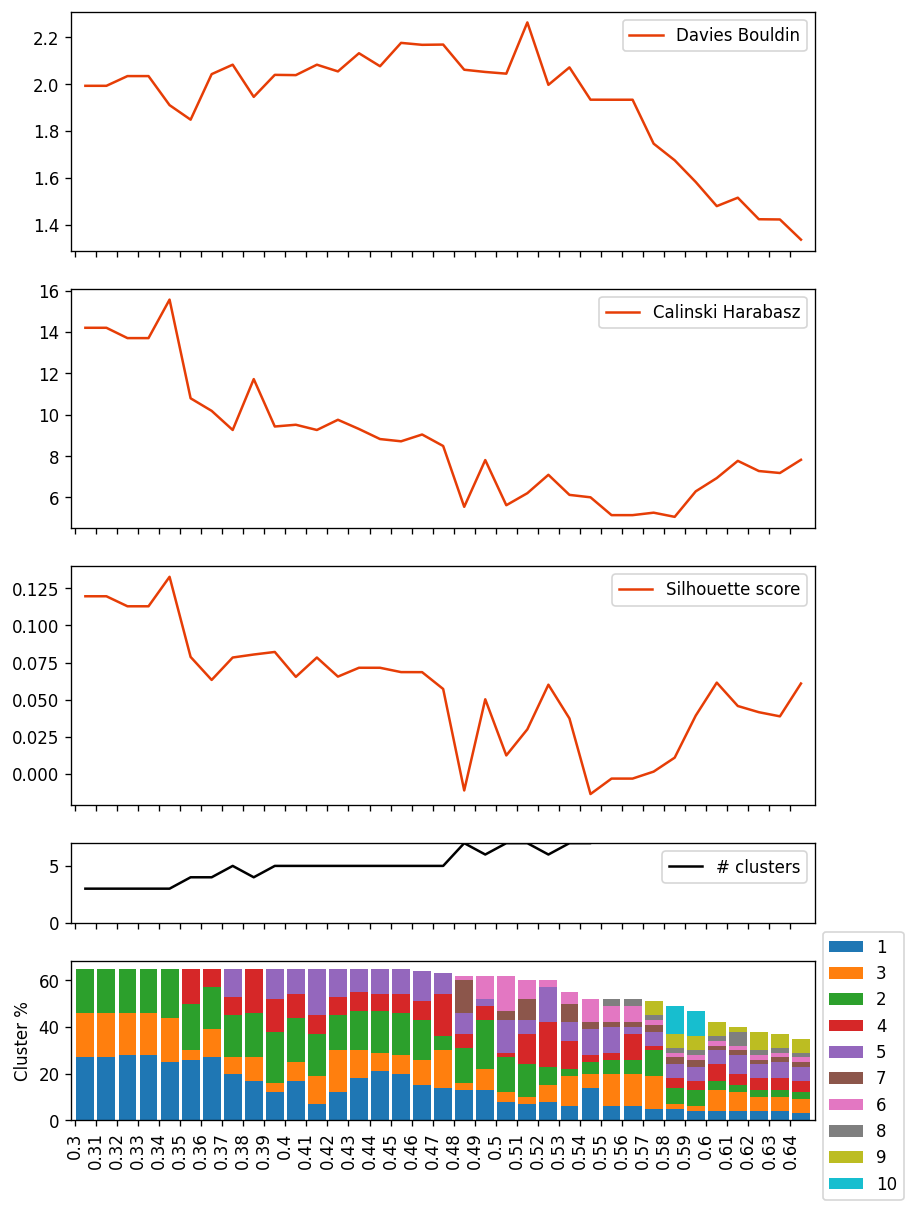

In [101]:
# Check the clustering within a range of 30 to 65% similarity.
# >65% - usually graph is not connected; <30% - unreasonable correlation
clustering_metrics = clustering_profile_metrics(signature_scores_scaled, threshold_mm=(.3, .65), step=.01)

# Visualize the partitions
clustering_profile_metrics_plot(clustering_metrics)

Plot above shows the count of clusters and their size for each threshold.

## Classification of each cluster/sample TME subtype 

In [102]:
 def detect_type(clustering_metrics: pd.DataFrame,scores: pd.DataFrame) -> pd.Series:

        clusters_number = clustering_metrics.loc['N'] 
        
        # samples_clustering is a pd.Series with patients as indexes and their clusters as values
        samples_clustering = clustering_metrics.loc['perc']
        cluster_means = pd.DataFrame({cluster: scores.loc[samples_clustering[samples_clustering == cluster].index].mean()
                                      for cluster in range(1, clusters_number + 1)})

        deltas = (cluster_means.loc[['Angiogenesis', 'Endothelium', 'CAF', 'Matrix', 'Matrix_remodeling']].mean() -
                  cluster_means.loc[['MHCII', 'Antitumor_cytokines', 'Coactivation_molecules',
                              'B_cells', 'NK_cells', 'Checkpoint_inhibition',
                              'Effector_cells', 'T_cells', 'Th1_signature',
                              'T_cell_traffic', 'MHCI']].mean()).sort_values()

        mapper = {}
        mapper[deltas.index[-1]] = 'F'  # The most fibrotic cluster is Fibrotic
        mapper[deltas.index[0]] = 'IE'  # The most immune cluster is Immune enriched, non-fibrotic

        # Remove detected clusters
        cluster_means.pop(deltas.index[-1])
        cluster_means.pop(deltas.index[0])

        deltas = (cluster_means.loc[['Angiogenesis', 'Endothelium', 'CAF', 'Matrix', 'Matrix_remodeling',
                              'Protumor_cytokines', 'Neutrophil_signature', 'Granulocyte_traffic',
                              'Macrophages', 'Macrophage_DC_traffic', 'MDSC_traffic', 'MDSC',
                              'Th2_signature', 'T_reg_traffic', 'Treg', 'M1_signatures', 'MHCII',
                              'Antitumor_cytokines', 'Coactivation_molecules', 'B_cells', 'NK_cells',
                              'Checkpoint_inhibition', 'Effector_cells', 'T_cells', 'Th1_signature',
                              'T_cell_traffic', 'MHCI', 'EMT_signature']].mean() -
                  cluster_means.loc['Proliferation_rate']).sort_values()

        mapper[deltas.index[0]] = 'D'  # The most proliferating cluster is (Immune) Desert
        mapper[deltas.index[-1]] = 'IE/F'  # Remains Immune enriched & fibrotic

        return samples_clustering.map(mapper).rename('MFP')

# Then select the best threshold using one or more metrics.
 best_threshold = '0.31'

# # Detect cluster types
 samples_subtyping_by_tme = detect_type(clustering_metrics.loc[best_threshold], signature_scores_scaled)

# # Output of the data into console
 print(samples_subtyping_by_tme)
    
# # Output the clusters
 samples_subtyping_by_tme.to_csv(SUBTYPE_FINAL_CLUSTERS, sep='\t', index=True)

GSM872328      IE
GSM872335       F
GSM872359      IE
GSM872378      IE
GSM872329    IE/F
             ... 
GSM872341       F
GSM872372       F
GSM872373       F
GSM872379      IE
GSM872349      IE
Name: MFP, Length: 65, dtype: object
